## Diffusion of Botanical Illustrations

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
#set_theme() 
#sns.set_theme(style="whitegrid",palette="PuOr_r")
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, OffsetImage, AnnotationBbox)
import os
import random
import requests
from io import BytesIO
import math

### 1. Collecting botanical illustrations based on results from multiple CLIP models

In [2]:
"""
Collect all examples for botanical illustrations
using classification scores from two CLIP models
"""
df_clip2 = pd.read_csv('./new_clip_classification(clip2).csv')
df_clip3 = pd.read_csv('./new_clip_classifications_with_2nd_candidate(clip3).csv')

In [3]:
df_class = df_clip2.merge(df_clip3, how='left', left_on = 'Image', right_on = 'Image')
agree = sum(df_class.Category_x == df_class.Category_y)
print(f'CLIP #2 and CLIP #3 agree on {agree} examples ({round(agree/len(df_class) * 100, 2)}%).')
agree = sum(df_class.Category_x == df_class.Second_choice)
print(f'CLIP #2 and CLIP #3 second choice agree on {agree} examples ({round(agree/len(df_class) * 100, 2)}%).')

CLIP #2 and CLIP #3 agree on 103909 examples (67.29%).
CLIP #2 and CLIP #3 second choice agree on 16885 examples (10.93%).


In [4]:
"""
Take a glance at examples that scored high in botanical in two CLIP models
"""
print('Results by CLIP model #2')
display(df_clip2[(df_clip2['Score'] > 90) & (df_clip2['Category'].isin(['botanical']))])

print('Results by CLIP model #3')
display(df_clip3[(df_clip3['Score'] > 90) & (df_clip3['Category'].isin(['botanical']))])

Results by CLIP model #2


Image   Category      Score
219     099320011900880_0.png  botanical  93.847656
225     120040010105160_3.png  botanical  90.869141
257     046120010300140_0.png  botanical  91.162109
282     031750010400250_0.png  botanical  90.136719
841     049030010306840_4.png  botanical  90.771484
...                       ...        ...        ...
153355  053900040002410_2.png  botanical  91.650391
153381  064340010101450_0.png  botanical  90.380859
153442  099320011800800_0.png  botanical  93.164062
153696  031750010401370_0.png  botanical  93.554688
153851  120040010109240_0.png  botanical  90.917969

[805 rows x 3 columns]

Results by CLIP model #3


Image   Category      Score Second_choice  2ndScore
36      054880050000090_0.png  botanical  90.478516        animal  6.872559
219     099320011900880_0.png  botanical  91.796875        animal  5.099487
1392    039510012401390_0.png  botanical  91.064453        animal  6.100464
1766    120050010203830_0.png  botanical  94.531250        animal  3.900146
2824    031750010300500_0.png  botanical  95.605469        animal  3.649902
...                       ...        ...        ...           ...       ...
152919  122130030000280_0.png  botanical  97.460938        animal  1.785278
153241  031750010401600_0.png  botanical  91.113281        animal  7.720947
153499  075230010203370_0.png  botanical  91.894531        animal  3.851318
153594  039520013401310_0.png  botanical  91.064453        animal  6.292725
153997  048550010203780_0.png  botanical  93.212891        animal  3.503418

[483 rows x 5 columns]

In [5]:
"""
Reducing false negatives by compared results by multple models is challenging.
This analysis does not examine potential false negatives, 
but focuses on reducing potential false positives as a strategy to 
downsample the number of illustrations for more downstream tasks.
"""

df_class['botanical'] = df_class.apply(lambda x: (x['Category_x'] == 'botanical') + (x['Category_y'] == 'botanical') + (x['Second_choice'] == 'botanical'), axis=1)

# potential false negatives
df_class[df_class['botanical'] == 1][['Category_x', 'Category_y', 'Second_choice']].value_counts()

Category_x         Category_y        Second_choice   
agri_garden        animal            botanical           2580
zoo_2              animal            botanical           2546
agri_garden        botanical         animal              1305
zoo_1              animal            botanical            687
misc               misc              botanical            505
microbio           microbio          botanical            189
architecture       architecture      botanical            184
agri_garden        botanical         misc                 116
                   misc              botanical             82
anatomy            anatomy           botanical             79
mechnanical_tools  mechanical_tools  botanical             71
agri_garden        mechanical_tools  botanical             67
mat_geo_astro      mat_geo_astro     botanical             64
agri_garden        architecture      botanical             51
                   botanical         architecture          48
zoo_1           

In [6]:
"""
Sampling scheme to reduce false positives

- Get all illustrations labeled "botanical" in at least two out of three criteria 
(CLIP #2, CLIP #3 and second choice of CLIP #3)
At this point we have all botanical illustrations by CLIP #2, which is either
labeled botanical by CLIP #3 or CLIP #3 second choice 

- Remove all images that CLIP #3 second choice labeled as botanical, 
but labeled something else by CLIP #3 with score higher than 50
"""

df_botanical = df_class[df_class['botanical'] >= 2]

filters = df_botanical[(df_botanical['Category_y'] != 'botanical') & (df_botanical['Score_y'] > 50)].Image
df_botanical = df_botanical[df_botanical['Image'].isin(filters) == False]
df_botanical

Image Category_x    Score_x Category_y    Score_y  \
8       097220010800110_0.png  botanical  83.398438  botanical  88.525391   
36      054880050000090_0.png  botanical  89.843750  botanical  90.478516   
39      028280080001530_1.png  botanical  76.220703  botanical  66.503906   
47      041230010200910_0.png  botanical  67.333984  botanical  46.459961   
98      038450020103080_1.png  botanical  52.832031  botanical  51.074219   
...                       ...        ...        ...        ...        ...   
154380  023990050100440_0.png  botanical  71.630859  botanical  75.292969   
154385  064340010101300_6.png  botanical  32.641602  botanical  31.372070   
154390  099330012201070_2.png  botanical  75.488281  botanical  70.751953   
154414  097220010800040_0.png  botanical  75.878906  botanical  75.488281   
154418  058050020005780_0.png  botanical  67.871094     animal  48.339844   

       Second_choice   2ndScore  botanical  
8             animal   8.898926          2  
36            animal   6.872559          2  
39            animal  28.149414          2  
47            animal  42.309570          2  
98            animal  28.637695          2  
...              ...        ...        ...  
154380        animal  20.910645          2  
154385        animal  22.949219          2  
154390        animal  21.252441          2  
154414        animal  15.332031          2  
154418     botanical  42.675781          2  

[13047 rows x 8 columns]

In [7]:
# Save sampled botanical illustrations to data directory
DATA_DIR = './sampled_botanical'
len(os.listdir(DATA_DIR))

# Due to technical issues with data retrieval, around 1000 images are missing

12119

### 2. Search for image reuses - Using resnet50 image embeddings 

This section is adapted from Ari Vesalainen (2023).

In [8]:
import torch
from torchvision import models, datasets, transforms
import numpy as np
import pickle
from numpy.linalg import norm
from tqdm import tqdm

In [9]:
# create transforms, Resnet expects the images are in format 256x256 pixels

tc = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()              
    ])

In [10]:
"""
Class for converting images to vectors, supports two Resnet-variants, i.e., Resnet-18 and Resnet-50
Resnet is excellent deep learning model for image classification, however, here only the feature extraction is used 
and fully connected layers are ignored.  
Output for Resnet-18 is a vector of 512 features and output for Resnet-50 is a vector of 2048 features. The feature
vectors are used to calculate the cosine similarity between two vectors, i.e., images, based on cosine similarity.  
"""

class Image2Vector():
    def __init__(self, modelType, transforms):
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.modelType = modelType
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.transforms = transforms
        self.model.eval()
        
    def getVector(self, img):
        image = self.transforms(img).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.layer_output_size, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)
       
        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]
    
    def getFeatureLayer(self):
        if self.modelType == "resnet18":
            model = models.resnet18(weights=True)
            self.layer_output_size = 512
        elif self.modelType == "resnet50":
            self.layer_output_size = 2048
            model = models.resnet50(weights=True)

        layer = model._modules.get('avgpool')
        
        return model, layer

In [11]:
"""
Load image feature vectors into dictionary where key is the file name of the image. Image vectors are stored on disk to
avoid unnecessary calulations
Input:
    modelType: type of deep learning model (Resnet-18 or Resnet-50) 
    db_dir: folder where feature vectors database is stored
    data_dir: folder for analyzed images
    transform: As model is based on Resnet, all input needs to be in 256x256 format 
Output:
    feature_vectors: dictionary of feature vectors, key is the file name of the image
    
"""

def loadVectors(modelType, db_dir, data_dir, transform=None):
    feature_vectors_path = os.path.join(db_dir,"feature_vectors_{}.pkl".format(modelType))
    
    # if feature vector database is already created, use it
    if os.path.exists(feature_vectors_path):
        print("Loading feature vectors from {}".format(feature_vectors_path))
        file = open(feature_vectors_path, 'rb')
        feature_vectors = pickle.load(file)  
        file.close()
    else: # otherwise create it using Image2Vector model and save it for further use
        img2vec = Image2Vector(modelType, transform)
        feature_vectors = {}
        print("File for feature vectors doesn't exist, converting images to feature vectors and saving those")
        for image in tqdm(os.listdir(data_dir)):
            I = Image.open(os.path.join(data_dir, image)).convert("RGB")
            vec = img2vec.getVector(I)
            feature_vectors[image] = vec
            I.close()
        with open(feature_vectors_path, 'wb') as handle:
            pickle.dump(feature_vectors, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return feature_vectors

In [12]:
"""
Calculate similarity between all images and store it in Dataframe

Input:
    vectors: dictionary of feature vectors, key is the file name of the image
Output:
    matrix: Pandas Dataframe, size #files x #files, cell items are cosine similarity between corresponding images 
"""

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix

"""
Create data structures to identify the k-most similar images (names and values)
Input:
    matrix:  Pandas Dataframe, size #files x #files, cell items are cosine similarity between corresponding images 
    modelType: type of deep learning model (Resnet-18 or Resnet-50)
    db_dir: folder where feature vectors database is stored
    k: number of most similar images to be stored for each image
Output
    similarNames: Dataframe, size #files x k to store k-most similar image names
    SimilarValues: Dataframe, size #files x k to store k-most similarity scores
"""

def createSimilarityDB(matrix, modelType, db_dir, k=5):

    similarNames = pd.DataFrame(index = matrix.index, columns = range(k))
    similarValues = pd.DataFrame(index = matrix.index, columns = range(k))

    for j in tqdm(range(matrix.shape[0])):
        kSimilar = matrix.iloc[j, :].sort_values(ascending = False).head(k)
        similarNames.iloc[j, :] = list(kSimilar.index)
        similarValues.iloc[j, :] = kSimilar.values
    similarNames_path = os.path.join(db_dir, "similarNames_{}.pkl".format(modelType))
    similarValues_path = os.path.join(db_dir, "similarValues_{}.pkl".format(modelType))
    similarNames.to_pickle(similarNames_path)
    similarValues.to_pickle(similarValues_path)
    return similarNames, similarValues

In [13]:
"""
Helper function to set labels when plotting
"""

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 8)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 8)
    ax.set_xticks([])
    ax.set_yticks([])

"""
Get the k-most similar images 
Input:
    image
    simNames
    SimValues
Output:
    imgs
    vals
"""

def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        return imgs[1:], vals[1:] # first item is image itself, so ignore it
    else:
        print("'{}' Unknown image".format(image))

In [14]:
"""
Plot images where the similarity has been detected, five images on one row

Input:
    image:  file name of the image
    input_dir: folder name for the image
    numCol: number of columns (=images) on one row
    numRow: number of rows in graph
    similarNames: Dataframe to included names of k-most similar images
    similarValues:  Dataframe to included similarity values of k-most similar images
"""                

def plotSimilarImages(image, input_dir, numCol, numRow, similarNames, similarValues):
    fig = plt.figure(figsize=(10, 20))
    
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)

    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0: # first plot the searhed image
            img = Image.open(os.path.join(input_dir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else: # and then k-most similar images found
            img = Image.open(os.path.join(input_dir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()

/Users/duongnguyen/data_processor/python_space/my-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading feature vectors from ./feature_vectors_resnet50.pkl


100%|████████████████████████████████████| 12119/12119 [00:12<00:00, 973.26it/s]


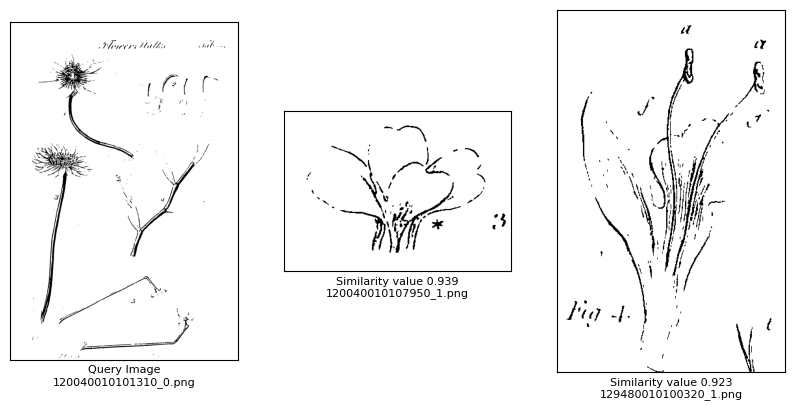

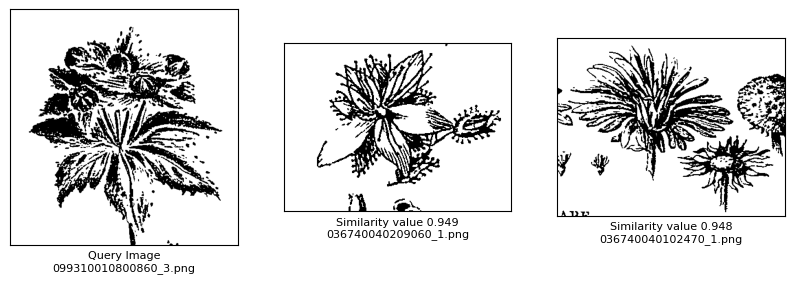

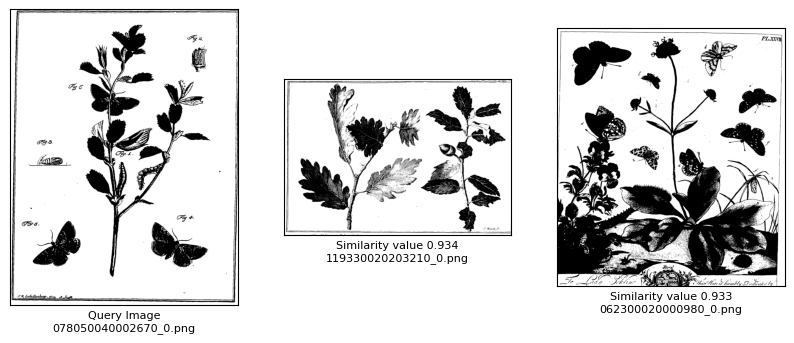

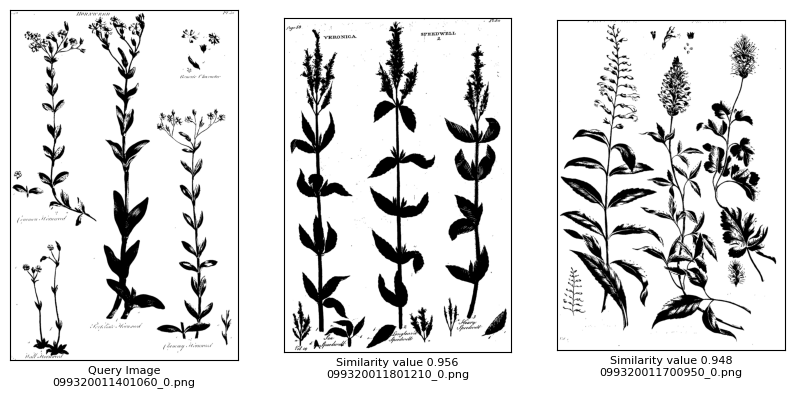

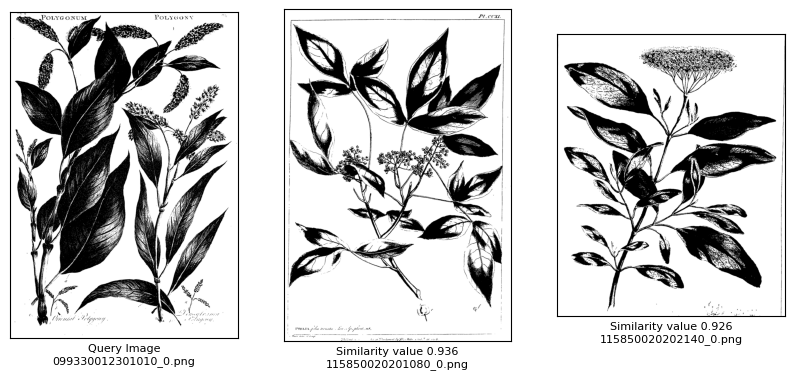

In [15]:
# Load image feature vector from repository or create if necessary. Select some images to be plotted and k-most similar images
# in same graph

modelType = "resnet50"
DB_DIR = "./"
img2vec = Image2Vector(modelType, tc)
feature_vectors_r50 = loadVectors(modelType, DB_DIR, DATA_DIR, tc)
similarityMatrix_r50 = getSimilarityMatrix(feature_vectors_r50)
simNames_r50, simValues_r50 = createSimilarityDB(similarityMatrix_r50, modelType, DB_DIR, 5)

numCol = 3
numRow = 1
num_files = 5
all_files = os.listdir(DATA_DIR)
# Shuffle the list of files randomly
random.shuffle(all_files)
selected_files = all_files

for image in selected_files[:num_files]:
    plotSimilarImages(image, DATA_DIR, numCol, numRow, simNames_r50, simValues_r50)

In [ ]:
"""
Based on the reported cutoff by Telma Peura (2023),
I set the cutoff to 0.91 for further exploration
"""
df_pairsim = pd.melt(similarityMatrix_r50.reset_index(), id_vars = ['index'], value_vars=similarityMatrix_r50.columns)
df_pairsim_cutoff = df_pairsim[df_pairsim['value'] > 0.91][df_pairsim['index'] != df_pairsim['variable']]
df_pairsim_cutoff.head()
# df_pairsim_cutoff.to_csv('botanical_similarity_cutoff-091.csv') # use this line to save the cutoff dataset

### 3. Illustration reuse analysis

In [16]:
# df_botanical = df_pairsim_cutoff.copy() # use this line if continue the previous cell
df_botanical = pd.read_csv('./botanical_similarity_cutoff-091.csv') # use this line to load the dataset from saved file

df_sim = pd.DataFrame()
df_sim['img_1'] = df_botanical.apply(lambda x: x['index'][:-4], axis=1)
df_sim['img_2'] = df_botanical.apply(lambda x: x['variable'][:-4], axis=1)
df_sim['cossim'] = df_botanical['value']
display(df_sim.info())
df_sim.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4205598 entries, 0 to 4205597
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   img_1   object 
 1   img_2   object 
 2   cossim  float64
dtypes: float64(1), object(2)
memory usage: 96.3+ MB


None

img_1              img_2    cossim
0  049030010306840_3  115480030103020_0  0.938916
1  049030010302370_2  115480030103020_0  0.920924
2  122840010001870_0  115480030103020_0  0.924923
3  110220030300370_0  115480030103020_0  0.914530
4  028280080000450_2  115480030103020_0  0.915823

In [17]:
df_meta = pd.read_csv('./merged_all.csv', dtype={'work_id': str, 'ecco_id': str})
display(df_meta.info())
df_meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154422 entries, 0 to 154421
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   page_allas_url          154422 non-null  object 
 1   illustration_id         154422 non-null  object 
 2   page_id                 154422 non-null  int64  
 3   illustration_allas_url  154422 non-null  object 
 4   ecco_id                 154340 non-null  object 
 5   page_number             154340 non-null  float64
 6   allas_page_url          154340 non-null  object 
 7   caption_texts           37036 non-null   object 
 8   estc_id                 154340 non-null  object 
 9   ecco_full_title         154340 non-null  object 
 10  number_of_pages         154340 non-null  float64
 11  language_primary        152761 non-null  object 
 12  gatherings              147971 non-null  object 
 13  publication_year        151252 non-null  float64
 14  publication_decade  

None

page_allas_url    illustration_id       page_id  \
0  000170010400180_0.png  000170010400180_0  170010400180   
1  000170010400180_1.png  000170010400180_1  170010400180   
2  000170010400370_0.png  000170010400370_0  170010400370   
3  000170010400500_0.png  000170010400500_0  170010400500   
4  000170010400500_1.png  000170010400500_1  170010400500   

                              illustration_allas_url     ecco_id  page_number  \
0  https://a3s.fi/dhh23-em-illu/000170010400180_0...  0001700104         18.0   
1  https://a3s.fi/dhh23-em-illu/000170010400180_1...  0001700104         18.0   
2  https://a3s.fi/dhh23-em-illu/000170010400370_0...  0001700104         37.0   
3  https://a3s.fi/dhh23-em-illu/000170010400500_0...  0001700104         50.0   
4  https://a3s.fi/dhh23-em-illu/000170010400500_1...  0001700104         50.0   

                                      allas_page_url caption_texts  estc_id  \
0  https://a3s.fi/dhh23-em-pages/000170010400180.png           NaN  T127210   
1  https://a3s.fi/dhh23-em-pages/000170010400180.png           NaN  T127210   
2  https://a3s.fi/dhh23-em-pages/000170010400370.png           NaN  T127210   
3  https://a3s.fi/dhh23-em-pages/000170010400500.png           NaN  T127210   
4  https://a3s.fi/dhh23-em-pages/000170010400500.png           NaN  T127210   

                                     ecco_full_title  ...  publication_decade  \
0  A system of surgery. By Benjamin Bell, Member ...  ...              1780.0   
1  A system of surgery. By Benjamin Bell, Member ...  ...              1780.0   
2  A system of surgery. By Benjamin Bell, Member ...  ...              1780.0   
3  A system of surgery. By Benjamin Bell, Member ...  ...              1780.0   
4  A system of surgery. By Benjamin Bell, Member ...  ...              1780.0   

                    work_id publication_place  publication_country  \
0  3257-a system of surgery         Edinburgh             Scotland   
1  3257-a system of surgery         Edinburgh             Scotland   
2  3257-a system of surgery         Edinburgh             Scotland   
3  3257-a system of surgery         Edinburgh             Scotland   
4  3257-a system of surgery         Edinburgh             Scotland   

   document_type                             sub_category  \
0           Book  scientificimprovementmedicineandanatomy   
1           Book  scientificimprovementmedicineandanatomy   
2           Book  scientificimprovementmedicineandanatomy   
3           Book  scientificimprovementmedicineandanatomy   
4           Book  scientificimprovementmedicineandanatomy   

                      authors category_clip score_clip       category_em  
0  Bell, Benjamin, 1749-1806.    mechanical  99.316406  Mechanical-Tools  
1  Bell, Benjamin, 1749-1806.         other  28.491211         Botanical  
2  Bell, Benjamin, 1749-1806.    mechanical  98.486328  Mechanical-Tools  
3  Bell, Benjamin, 1749-1806.    mechanical  91.308594  Mechanical-Tools  
4  Bell, Benjamin, 1749-1806.         other  47.436523  Mechanical-Tools  

[5 rows x 24 columns]

In [25]:
"""
Sort illustration pairs by year order 
(illustration A - illustration B if A was published before B)
"""
img_att = df_meta[['illustration_id', 'publication_year', 'work_id']].set_index(['illustration_id']).to_dict('index')
df_sim['reversed'] = df_sim.apply(lambda x: img_att[x['img_1']]['publication_year'] > img_att[x['img_2']]['publication_year'], axis=1)

sorted_sim = pd.DataFrame()
sorted_sim['img_1'] = df_sim.apply(lambda x: x['img_1'] if x['reversed'] == False else x['img_2'], axis=1)
sorted_sim['img_2'] = df_sim.apply(lambda x: x['img_2'] if x['reversed'] == False else x['img_1'], axis=1)
sorted_sim['cossim'] = df_sim.apply(lambda x: x['cossim'], axis=1)
sorted_sim = sorted_sim.drop_duplicates()

sorted_sim['same_book'] = sorted_sim.apply(lambda x: x['img_1'].split('_')[0][:-5] == x['img_2'].split('_')[0][:-5], axis=1)
sorted_sim['reprint'] = sorted_sim.apply(lambda x: img_att[x['img_1']]['work_id'] == img_att[x['img_2']]['work_id'], axis=1)

sorted_sim

img_1              img_2    cossim  same_book  reprint
0        049030010306840_3  115480030103020_0  0.938916      False    False
1        049030010302370_2  115480030103020_0  0.920924      False    False
2        122840010001870_0  115480030103020_0  0.924923      False    False
3        110220030300370_0  115480030103020_0  0.914530      False    False
4        115480030103020_0  028280080000450_2  0.915823      False    False
...                    ...                ...       ...        ...      ...
4205593  031750010400510_0  031750010301380_0  0.910491      False     True
4205594  031750010401320_0  031750010301380_0  0.923351      False     True
4205595  031750010400880_0  031750010301380_0  0.919599      False     True
4205596  031750010301340_0  031750010301380_0  0.920658       True     True
4205597  031750010301570_0  031750010301380_0  0.919229       True     True

[2444490 rows x 5 columns]

In [26]:
"""
Reuses in the same book or reprinted versions
"""
reprint_reuses=sorted_sim[(sorted_sim['same_book'] == False) & (sorted_sim['reprint'] == True)]
print(f'{sum(sorted_sim.same_book)} reuse pairs ({round(sum(sorted_sim.same_book)/len(sorted_sim)*100, 2)} %) with illustrations from the same book.')
print(f'{len(reprint_reuses)} reuse pairs ({round(len(reprint_reuses)/len(sorted_sim)*100, 2)} %) with illustrations from reprinted versions of the same work.')

172358 reuse pairs (7.05 %) with illustrations from the same book.
468153 reuse pairs (19.15 %) with illustrations from reprinted versions of the same work.


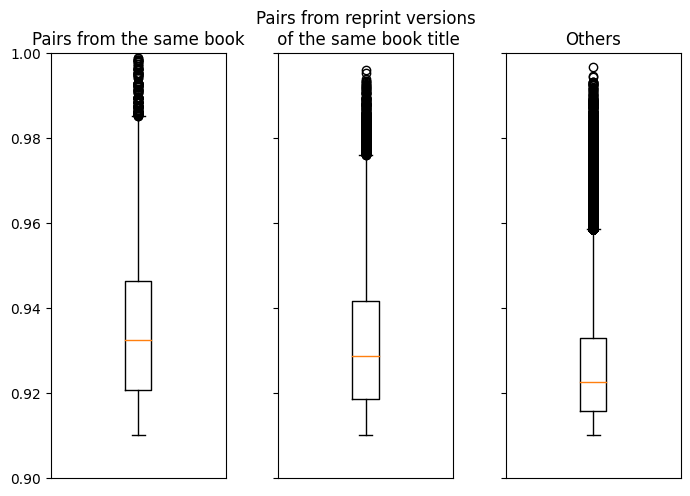

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(7, 5), sharey=True)

axs[0].boxplot(sorted_sim[sorted_sim['same_book'] == True].cossim)
axs[0].set_title('Pairs from the same book')
axs[0].set_xticks([])
axs[0].set_yticks([0.90, 0.92, 0.94, 0.96, 0.98, 1])

axs[1].boxplot(reprint_reuses.cossim)
axs[1].set_title('Pairs from reprint versions\n of the same book title')
axs[1].set_xticks([])
axs[1].set_yticks([0.90, 0.92, 0.94, 0.96, 0.98, 1])

axs[2].boxplot(sorted_sim[sorted_sim['reprint'] == False].cossim)
axs[2].set_title('Others')
axs[2].set_xticks([])
axs[2].set_yticks([0.90, 0.92, 0.94, 0.96, 0.98, 1])

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

plt.ylim(0.90, 1.0)
# plt.legend(['Pairs from the same book', 'Pairs from reprint versions of the same book title', 'Others'])
plt.show()

Distribution of cosine similarity score


index        cossim
0  count  1.803979e+06
1   mean  9.254721e-01
2    std  1.229258e-02
3    min  9.100001e-01
4    25%  9.155577e-01
5    50%  9.225740e-01
6    75%  9.327139e-01
7    max  9.966350e-01

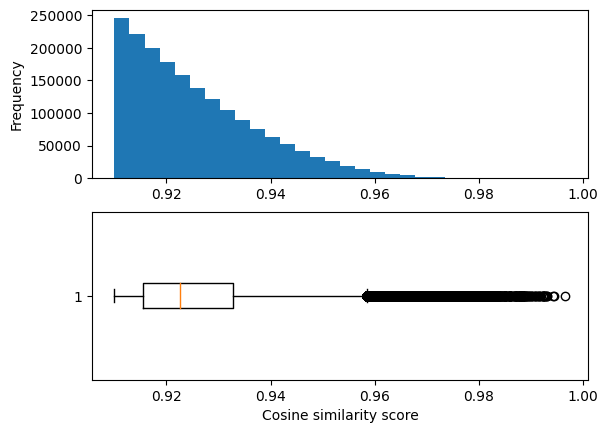

Distribution of # of reuses


index        count
0  count  8807.000000
1   mean   204.834677
2    std   320.409339
3    min     1.000000
4    25%     7.000000
5    50%    49.000000
6    75%   271.000000
7    max  2248.000000

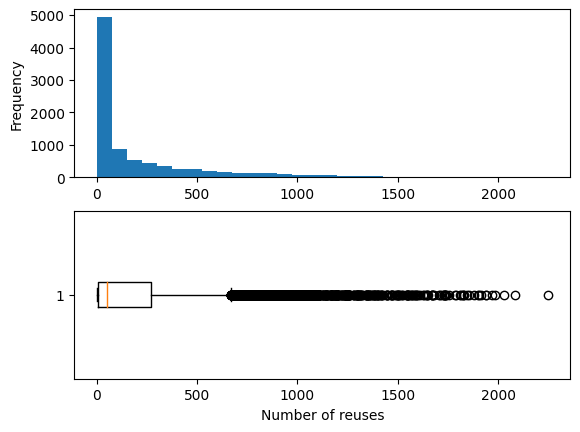

In [28]:
"""
Distribution of cosine similarity score and number of reuses 
(excluding examples from the same book or reprinted versions)
"""
data = sorted_sim[sorted_sim['reprint'] == False].sort_values(by=['cossim'])
print('Distribution of cosine similarity score')
display(data.cossim.describe().reset_index())

# plot 
ax1 = plt.subplot(211)
ax1.hist(data.cossim, bins = 30)
plt.ylabel('Frequency')
ax2 = plt.subplot(212)
ax2.boxplot(data.cossim, vert=False)
plt.xlabel('Cosine similarity score')
plt.show()

n_reuses = data.img_1.value_counts().reset_index()

print('Distribution of # of reuses')
display(n_reuses['count'].describe().reset_index())

# plot 
ax1 = plt.subplot(211)
ax1.hist(n_reuses['count'], bins = 30)
plt.ylabel('Frequency')
ax2 = plt.subplot(212)
ax2.boxplot(n_reuses['count'], vert=False)
plt.xlabel('Number of reuses')
plt.show()

In [29]:
"""
Get 5 most similar reuses for each illustration
"""
k = 5
index = [img+'.png' for img in set(data.img_1)]
similarNames = pd.DataFrame(index = index, columns = range(k))
similarValues = pd.DataFrame(index = index, columns = range(k))

for img in set(data.img_1):
    kSimilar = data[data['img_1'] == img].sort_values(by='cossim', ascending=False).head(5)
    
    sim_names = list([img+'.png' for img in kSimilar.img_2])
    sim_vals = list(kSimilar.cossim)
    
    similarNames.loc[img+'.png'] =  sim_names + [''] * (k - len(sim_names))
    similarValues.loc[img+'.png'] = sim_vals + [0] * (k - len(sim_vals))
    
"""
Save the results
"""
f = open(f'{DB_DIR}/simNames_{modelType}.pkl', 'wb')
pickle.dump(similarNames,f)
f.close()

f = open(f'{DB_DIR}/simValues_{modelType}.pkl', 'wb')
pickle.dump(similarValues,f)
f.close()

In [30]:
"""
Load saved results
"""
f = open(f'{DB_DIR}/simNames_{modelType}.pkl', 'rb')
simNames = pickle.load(f)
f.close()

f = open(f'{DB_DIR}/simValues_{modelType}.pkl', 'rb')
simValues = pickle.load(f)
f.close()

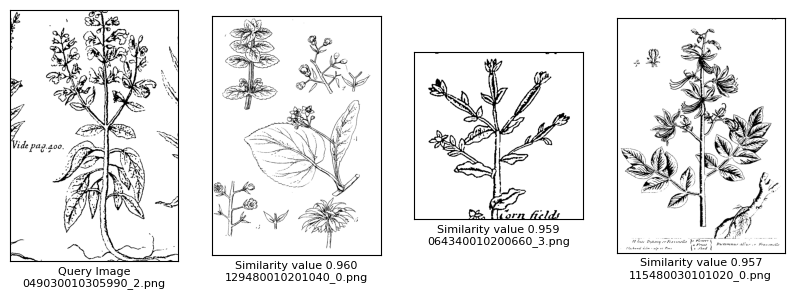

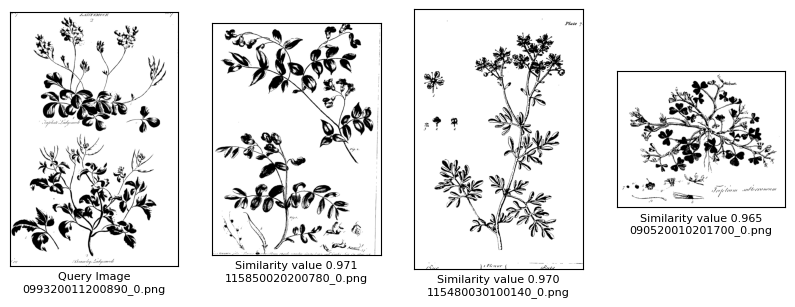

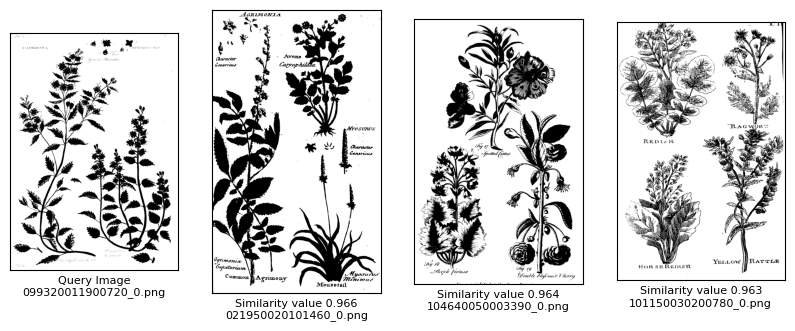

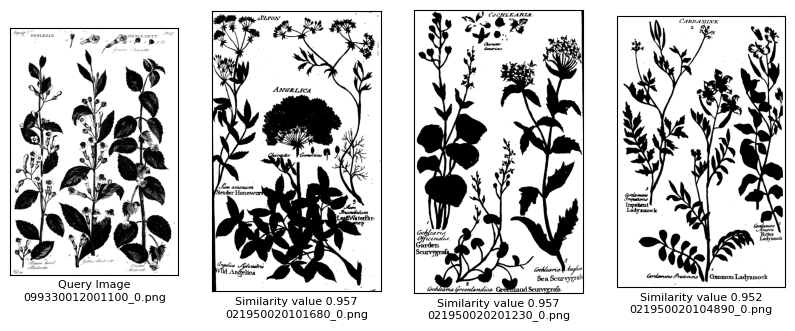

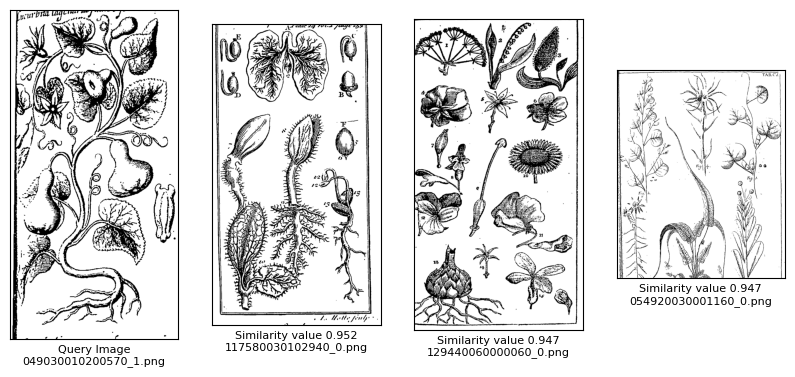

In [31]:
"""
Plot top 3 most similar reuses for a chosen set of 5 random sampled illustrations
"""
DATA_DIR = "./sampled_botanical"
numCol = 4
numRow = 1
num_files = 5
all_files = list(data.img_1)
# Shuffle the list of files randomly
random.shuffle(all_files)
selected_files = [file+'.png' for file in all_files[:num_files]]

def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        return imgs, vals # do not ignore first items
    else:
        print("'{}' Unknown image".format(image))
        
for image in selected_files:
    plotSimilarImages(image, DATA_DIR, numCol, numRow, simNames, simValues)

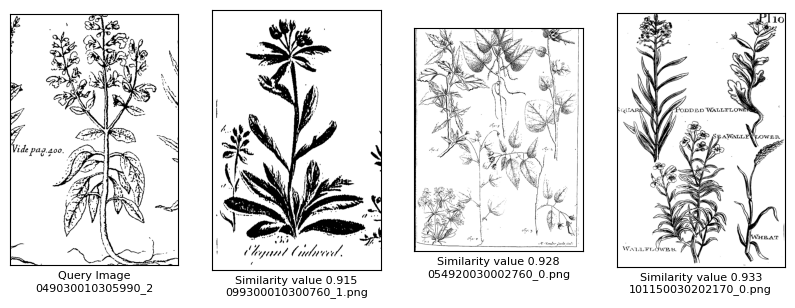

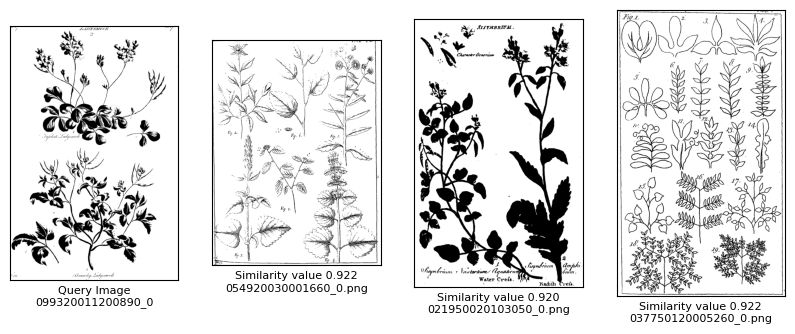

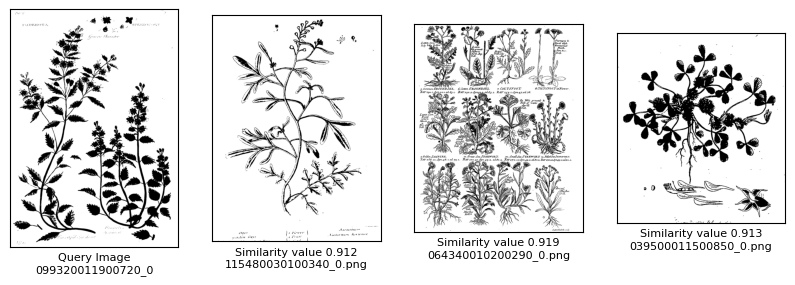

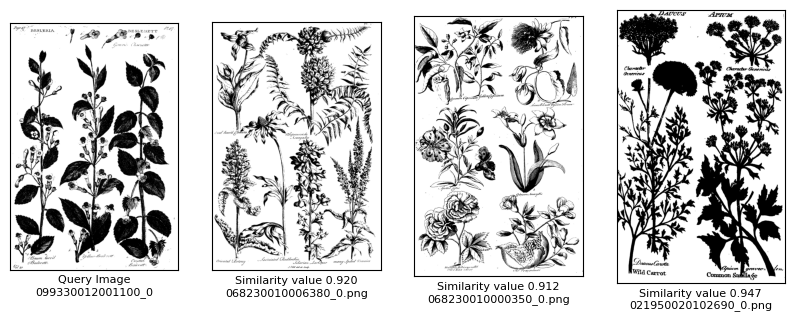

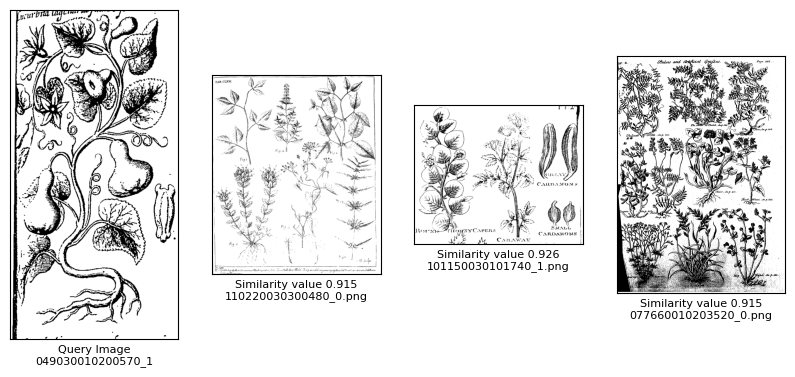

In [32]:
"""
Plot  reuses (randomly selected) for the same chosen set above
"""
numCol = 4
numRow = 1

for image in selected_files:
    image = image[:-4]
    fig = plt.figure(figsize=(10, 20))

    sampled_reuses = data[data['img_1'] == image].sample(frac=1)
    simImages = [img+'.png' for img in sampled_reuses.img_2]
    simValues = list(sampled_reuses.cossim)

    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0: # first plot the searched image
            img = Image.open(os.path.join(DATA_DIR, image + '.png'))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else: # and then k-most similar images found
            img = Image.open(os.path.join(DATA_DIR, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()

    plt.show()

--------------------------------------------

#### Side task 1: Chain of reuses
- Problem: After stripping all image pairs from the same books/reprint versions of the same work, theshold 0.91 does not give close enough identifications. Some searched similar images resemble each other rather than resembling the query image.
- Approach: Push the threshold up to return only exact matches as reuses, then collect exhaustively all reuses of reuses (which are also identified by the same high threshold).

In [33]:
def get_all_reuses(img, sorted_sim_df):
    reuse_trace = {}
    reuse_trace[0] = [img]
    depth = 0
    has_next = True

    while has_next == True:

        depth += 1
#         print(depth)
        reuse_trace[depth] = []

        for img in reuse_trace[depth-1]:
            reuse_trace[depth] += [item for item in sorted_sim_df[sorted_sim_df['img_1'] == img].img_2]

        if depth < 2 and reuse_trace[depth] != []:
            has_next = True
        elif [item for item in reuse_trace[depth] if item in reuse_trace[depth-2]] == [] and reuse_trace[depth] != []:
            has_next = True
        else:
            has_next = False
            
#     reuses = []
#     for i in range(1, len(reuse_trace)):
#         reuses += reuse_trace[i]
    
    return reuse_trace

"""
Threshold 0.95 is selected heuristically based on similarity scores from top 5 most similar searched images
"""
reuse_dict = {}
sorted_sim_df = data[data['cossim'] > 0.95]
for image in selected_files:
    image = image[:-4]
    print(image)
    reuse_dict[image] = get_all_reuses(image, sorted_sim_df)

049030010305990_2
099320011200890_0
099320011900720_0
099330012001100_0
049030010200570_1


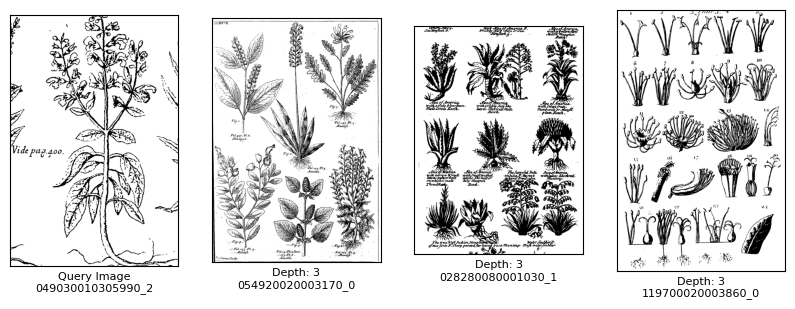

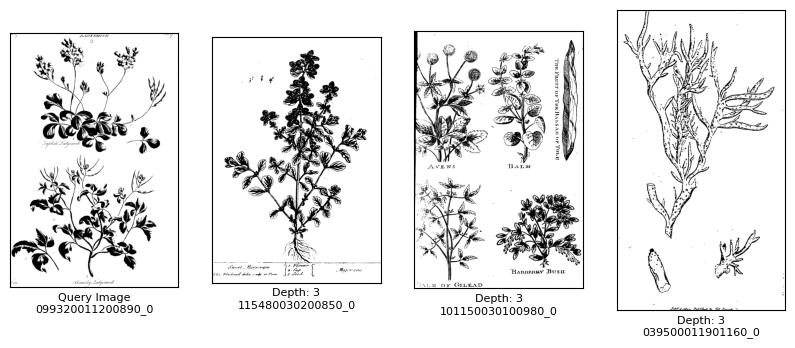

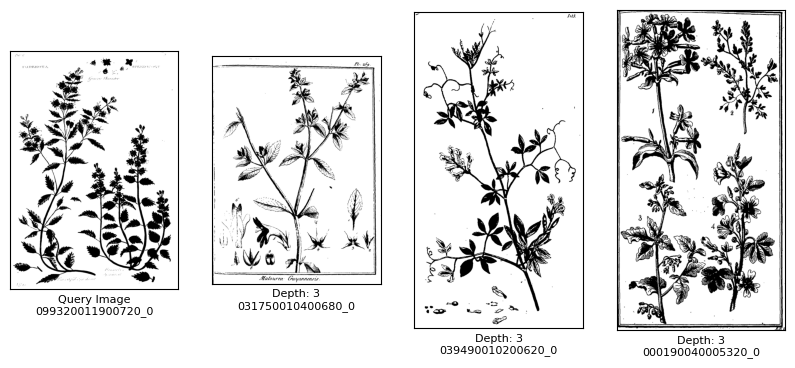

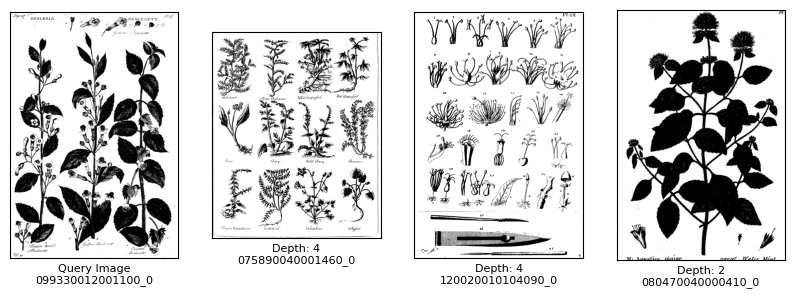

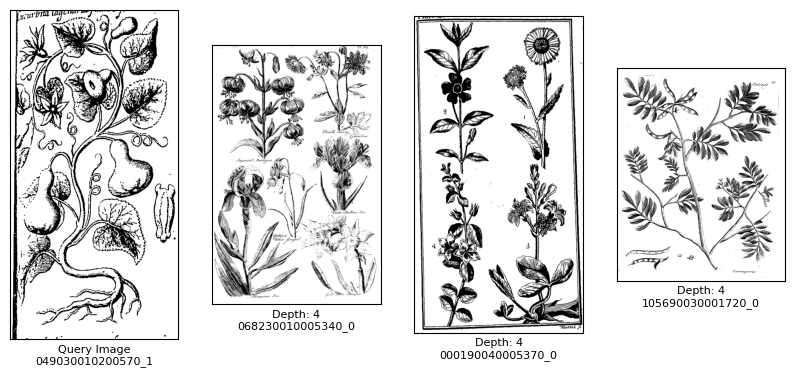

In [36]:
"""
Plot 5 random selected reuses (including reuses of reuses) for the same chosen set above
"""
numCol = 4
numRow = 1

for image in selected_files:
    image = image[:-4]
    fig = plt.figure(figsize=(10, 20))
    
    trace = reuse_dict[image]
    reuse_depth = {}
    for i in range(1, len(trace)):
        for img in trace[i]:
            reuse_depth[img+'.png'] = i
    
    try:
        simImages = random.sample(list(reuse_depth.keys()), numCol*numRow)
    except:
        simImages = list(reuse_depth.keys())
    simValues = [reuse_depth[image] for image in simImages]

    for j in range(0, numCol*numRow):
        ax = []
        if j == 0: # first plot the searched image
            img = Image.open(os.path.join(DATA_DIR, image + '.png'))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else: # and then k-most similar images found
            try:
                img = Image.open(os.path.join(DATA_DIR, simImages[j-1]))
                ax.append(fig.add_subplot(numRow, numCol, j+1))
                ax[-1].set_xlabel(f'Depth: {int(simValues[j-1])}\n{simImages[j-1][:-4]}', fontsize = 8)
                ax[-1].set_xticks([])
                ax[-1].set_yticks([])
            except:
                pass
            
        img = img.convert('RGB')
        plt.imshow(img)
#         img.close()

    plt.show()

---------------------------------------

### 4. Examining the Diffusion of Innovation Theory with image reuses

count
count  4832.000000
mean     51.084230
std      85.481587
min       1.000000
25%       2.000000
50%      12.000000
75%      60.000000
max     722.000000

Distribution of # of reuses


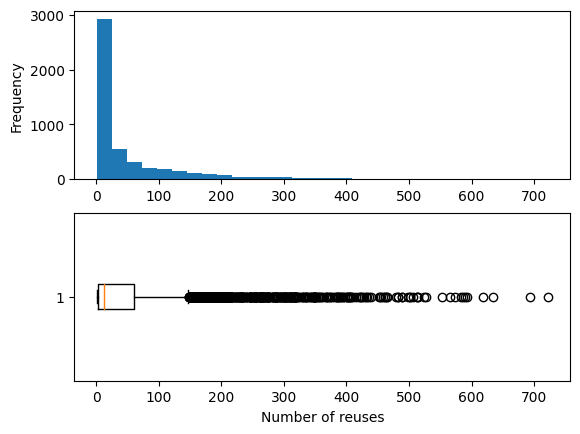

In [37]:
"""
The reuses of reuses approach is not evidently better than threshold 0.91.
Select a higher threshold for cosine similarity 0.94 for mostly exact matches as reuses
Check the distribution of number of reuses
"""
reuses_094 = data[data['cossim'] >= 0.94].img_1.value_counts().reset_index()
display(reuses_094.describe())

print('Distribution of # of reuses')

# plot 
ax1 = plt.subplot(211)
ax1.hist(reuses_094['count'], bins = 30)
plt.ylabel('Frequency')
ax2 = plt.subplot(212)
ax2.boxplot(reuses_094['count'], vert=False)
plt.xlabel('Number of reuses')
plt.show()

In [38]:
"""
Connect the similarity data with metadata to create a new dataset for diffusion analysis
"""
illu_id = dict(zip(df_meta.illustration_id, df_meta.ecco_id))
id_format = dict(zip(df_meta.ecco_id, df_meta.gatherings))
id_year = dict(zip(df_meta.ecco_id, df_meta.publication_year))
id_work = dict(zip(df_meta.ecco_id, df_meta.work_id))

diffusion_094 = data[data['cossim'] >= 0.94]
# add work ids and classify if it's a reprint pair
diffusion_094['ecco_1'] = diffusion_094.apply(lambda x: illu_id[x['img_1']], axis=1)
diffusion_094['ecco_2'] = diffusion_094.apply(lambda x: illu_id[x['img_2']], axis=1)
diffusion_094['work_1'] = diffusion_094.apply(lambda x: id_work[x.ecco_1], axis=1)
diffusion_094['work_2'] = diffusion_094.apply(lambda x: id_work[x.ecco_2], axis=1)
diffusion_094['format_1'] = diffusion_094.apply(lambda x: id_format[x.ecco_1], axis=1)
diffusion_094['format_2'] = diffusion_094.apply(lambda x: id_format[x.ecco_2], axis=1)
diffusion_094['year_1'] = diffusion_094.apply(lambda x: id_year[x.ecco_1], axis=1)
diffusion_094['year_2'] = diffusion_094.apply(lambda x: id_year[x.ecco_2], axis=1)

diffusion_094.info()
diffusion_094.iloc[:5]

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/3085385527.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffusion_094['ecco_1'] = diffusion_094.apply(lambda x: illu_id[x['img_1']], axis=1)
/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/3085385527.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffusion_094['ecco_2'] = diffusion_094.apply(lambda x: illu_id[x['img_2']], axis=1)
/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/3085385527.py:13: Sett

<class 'pandas.core.frame.DataFrame'>
Index: 246839 entries, 2313871 to 625938
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   img_1      246839 non-null  object 
 1   img_2      246839 non-null  object 
 2   cossim     246839 non-null  float64
 3   same_book  246839 non-null  bool   
 4   reprint    246839 non-null  bool   
 5   ecco_1     246839 non-null  object 
 6   ecco_2     246839 non-null  object 
 7   work_1     246839 non-null  object 
 8   work_2     246839 non-null  object 
 9   format_1   214063 non-null  object 
 10  format_2   216098 non-null  object 
 11  year_1     246591 non-null  float64
 12  year_2     246591 non-null  float64
dtypes: bool(2), float64(3), object(8)
memory usage: 23.1+ MB


/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/3085385527.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffusion_094['year_2'] = diffusion_094.apply(lambda x: id_year[x.ecco_2], axis=1)


img_1              img_2  cossim  same_book  reprint  \
2313871  099310010601030_0  068230010005990_0    0.94      False    False   
2567368  099320011700980_0  082460030001490_0    0.94      False    False   
82057    049030010200540_1  110220030200390_0    0.94      False    False   
439375   049030010305870_3  090510010104980_0    0.94      False    False   
913878   039510012200270_0  052080010500630_0    0.94      False    False   

             ecco_1      ecco_2  \
2313871  0993100106  0682300100   
2567368  0993200117  0824600300   
82057    0490300102  1102200302   
439375   0490300103  0905100101   
913878   0395100122  0520800105   

                                                    work_1  \
2313871  22710-vegetable system or series of experiment...   
2567368  22710-vegetable system or series of experiment...   
82057    8252-plantarum historiae universalis oxoniensi...   
439375   8252-plantarum historiae universalis oxoniensi...   
913878                               105904-english botany   

                                                    work_2 format_1 format_2  \
2313871  46433-eden or compleat body of gardening both ...      2fo      2fo   
2567368  211-english physitian enlarged with three hund...      2fo      4to   
82057    158152-leonardi plukenetii md opera omnia bota...      2fo      NaN   
439375                                            X-T83980      2fo      2fo   
913878                                            X-T88189      8vo      NaN   

         year_1  year_2  
2313871  1759.0  1773.0  
2567368  1759.0  1789.0  
82057    1715.0  1720.0  
439375   1715.0  1777.0  
913878   1790.0  1797.0

In [39]:
summary = diffusion_094.describe()
summary['work_1'] = diffusion_094.work_1.value_counts().describe()
summary['work_2'] = diffusion_094.work_2.value_counts().describe()
summary = summary.round(decimals=2)
summary

cossim     year_1     year_2    work_1    work_2
count  246839.00  246591.00  246591.00    166.00    166.00
mean        0.95    1742.46    1771.76   1486.98   1486.98
std         0.01      25.22      19.48   6451.86   4593.41
min         0.94    1686.00    1686.00      1.00      1.00
25%         0.94    1715.00    1760.00      3.00      5.00
50%         0.95    1756.00    1769.00     38.50     50.00
75%         0.95    1759.00    1787.00    243.25    449.75
max         1.00    1800.00    1800.00  55019.00  32043.00

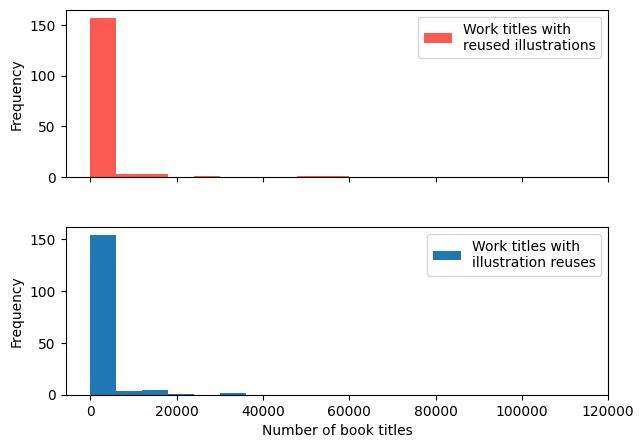

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

axs[0].hist(diffusion_094.work_1.value_counts(), bins=np.arange(0, 120000, 6000), color='xkcd:coral')
axs[0].set_ylabel('Frequency')
# axs[0].set_xlabel('Number of book titles')
# axs[0].set_xticks([0, 20000, 40000, 60000, 80000, 100000, 120000])
axs[0].legend(['Work titles with \nreused illustrations'])

axs[1].hist(diffusion_094.work_2.value_counts(), bins=np.arange(0, 120000, 6000))
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Number of book titles')
axs[1].set_xticks([0, 20000, 40000, 60000, 80000, 100000, 120000])
axs[1].legend(['Work titles with \nillustration reuses'])

fig.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

-------------------------------------------

#### Side task 2: Understanding the botanical book market over years
- The naive approach to market size: market size growth is equal with number of new works published each year
- Taking into account die-outs (some works got outdated and stopped getting republished after a certain time range)

Text(0.5, 1.0, 'Bontanical book market over years')

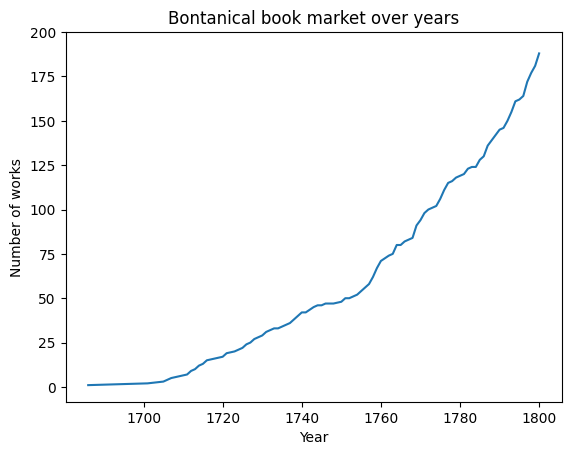

In [41]:
"""
The naive approach
"""
botanical_works = list(set(list(diffusion_094.ecco_1) + list(diffusion_094.ecco_2)))
df_botanicalwork = df_meta[df_meta['ecco_id'].isin(botanical_works)]
year_work = {}
prior_size = []
for year in df_botanicalwork.sort_values(by='publication_year').publication_year.drop_duplicates():
    add = [item for item in list(df_botanicalwork[df_botanicalwork['publication_year'] == year][['work_id', 'publication_year']].drop_duplicates().work_id) if item not in prior_size]
    prior_size += add
    year_work[year] = add

market_growth = np.array([len(value) for value in year_work.values()])
plt.plot(year_work.keys(), market_growth.cumsum())
plt.ylim(top=200)
plt.ylabel('Number of works')
plt.xlabel('Year')
plt.title('Bontanical book market over years')

How many years did a work get republished?


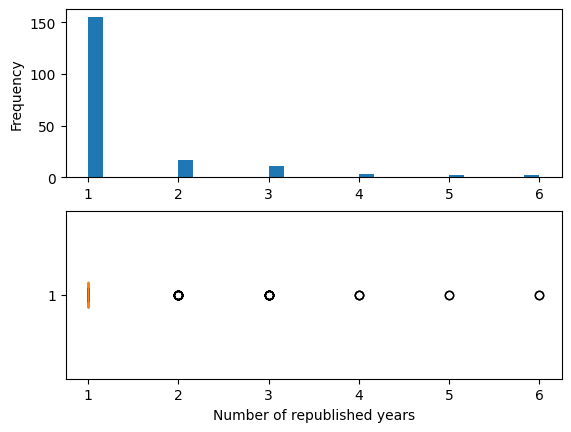

In [43]:
"""
How did a work die out? 
Examining republication of works
"""

print('How many years did a work get republished?')
work_year = {}
for work_id in df_botanicalwork['work_id'].drop_duplicates():
    work_year[work_id]=list(df_botanicalwork[df_botanicalwork['work_id'] == work_id][['publication_year']].drop_duplicates().sort_values(by='publication_year').publication_year)

# plot 
ax1 = plt.subplot(211)
ax1.hist([len(years) for years in work_year.values()], bins=30)
plt.ylabel('Frequency')
ax2 = plt.subplot(212)
ax2.boxplot([len(years) for years in work_year.values()], vert=False)
plt.xlabel('Number of republished years')
plt.show()

18.42 % of works are long sellers - duration of republication longer than 1 year.
How many years on average did it take for a long-selling work to get republished?


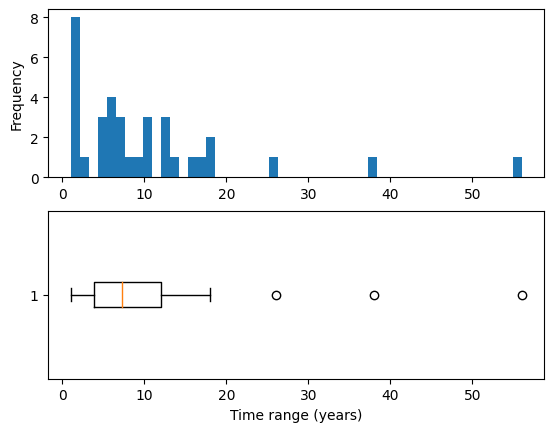

count    35.000000
mean     10.257619
std      11.111662
min       1.000000
25%       3.900000
50%       7.250000
75%      12.000000
max      56.000000
dtype: float64

In [45]:
"""
Some works got republished frequently in a short time span,
while other works got republished many years after their last publication (long-sellers).
"""

long_sellers = {key: (value[-1] - value[0])/(len(value)-1) for key, value in work_year.items() if len(value) > 1} 
print(f'{round(len(long_sellers)/len(work_year) * 100, 2)} % of works are long sellers - duration of republication longer than 1 year.') 
print('How many years on average did it take for a long-selling work to get republished?')
# plot 
ax1 = plt.subplot(211)
ax1.hist(long_sellers.values(), bins=50)
plt.ylabel('Frequency')
ax2 = plt.subplot(212)
ax2.boxplot(long_sellers.values(), vert=False)
plt.xlabel('Time range (years)')
plt.show()

pd.Series(long_sellers.values()).describe()

In [47]:
"""
Setting the time limit to expect republication to 20 years.
Only 3 long sellers got republished after more than 20 years since their last publcation/republication.

Create a matrix of work_id x year 
If work_id A was published/republished in year a, its presence remains in the market from year a to year a+15
"""

years = [year for year in range(1686, 1801)]
df_market = pd.DataFrame(columns=years, index=df_botanicalwork.work_id.drop_duplicates().sort_values())

for work_id in df_market.index:
    
    df_market.loc[work_id] = [False] * len(years)
    
    presence = []
    for year in work_year[work_id]:
        if math.isnan(year) == False:
            presence += [item for item in list(np.arange(0, 21, 1) + year) if item <= 1800]

    presence = list(set(presence))

    for year in presence:
        df_market.loc[[work_id], [year]] = True
    
display(df_market.head())

df_market.loc['total'] = df_market.sum(axis=0)

1686.0 1687.0 1688.0  \
work_id                                                                   
101136-micrographia illustrata or microscope ex...  False  False  False   
1013-etudes de la nature                            False  False  False   
10261-a compleat body of husbandry                  False  False  False   
10286-flora scotica or systematic arrangement i...  False  False  False   
102916-jacobi petiveri opera historiam naturale...  False  False  False   

                                                   1689.0 1690.0 1691.0  \
work_id                                                                   
101136-micrographia illustrata or microscope ex...  False  False  False   
1013-etudes de la nature                            False  False  False   
10261-a compleat body of husbandry                  False  False  False   
10286-flora scotica or systematic arrangement i...  False  False  False   
102916-jacobi petiveri opera historiam naturale...  False  False  False   

                                                   1692.0 1693.0 1694.0  \
work_id                                                                   
101136-micrographia illustrata or microscope ex...  False  False  False   
1013-etudes de la nature                            False  False  False   
10261-a compleat body of husbandry                  False  False  False   
10286-flora scotica or systematic arrangement i...  False  False  False   
102916-jacobi petiveri opera historiam naturale...  False  False  False   

                                                   1695.0  ... 1791.0 1792.0  \
work_id                                                    ...                 
101136-micrographia illustrata or microscope ex...  False  ...   True  False   
1013-etudes de la nature                            False  ...  False  False   
10261-a compleat body of husbandry                  False  ...  False  False   
10286-flora scotica or systematic arrangement i...  False  ...   True   True   
102916-jacobi petiveri opera historiam naturale...  False  ...  False  False   

                                                   1793.0 1794.0 1795.0  \
work_id                                                                   
101136-micrographia illustrata or microscope ex...  False  False  False   
1013-etudes de la nature                            False  False  False   
10261-a compleat body of husbandry                  False  False  False   
10286-flora scotica or systematic arrangement i...   True   True   True   
102916-jacobi petiveri opera historiam naturale...  False  False  False   

                                                   1796.0 1797.0 1798.0  \
work_id                                                                   
101136-micrographia illustrata or microscope ex...  False  False  False   
1013-etudes de la nature                            False  False   True   
10261-a compleat body of husbandry                  False  False  False   
10286-flora scotica or systematic arrangement i...   True   True   True   
102916-jacobi petiveri opera historiam naturale...  False  False  False   

                                                   1799.0 1800.0  
work_id                                                           
101136-micrographia illustrata or microscope ex...  False  False  
1013-etudes de la nature                             True   True  
10261-a compleat body of husbandry                  False  False  
10286-flora scotica or systematic arrangement i...   True   True  
102916-jacobi petiveri opera historiam naturale...  False  False  

[5 rows x 115 columns]

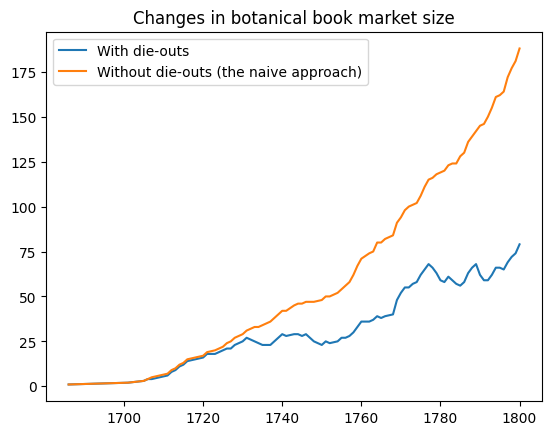

In [48]:
market_wdieout = df_market.loc['total'].reset_index().rename(columns={'index':'year', 'total':'size'})

plt.plot(market_wdieout[market_wdieout['year'].isin(year_work.keys())].set_index('year'))
plt.plot(pd.Series(market_growth.cumsum(), index=year_work.keys()))
plt.title('Changes in botanical book market size')
plt.legend(['With die-outs', 'Without die-outs (the naive approach)'])
plt.show()

# market_wdieout['decade'] = market_wdieout.apply(lambda x: int(x['year']/10)*10, axis=1)

In [69]:
# Number of botanical illustrations in each decade
botanical_illus = df_class[df_class['botanical'] >= 2]
botanical_illus = botanical_illus[botanical_illus['Image'].isin(filters) == False]
botanical_illus['illustration_id'] = botanical_illus.apply(lambda x: x['Image'][:-4], axis=1)

df_meta[df_meta['illustration_id'].isin(botanical_illus['illustration_id'])]['publication_decade'].value_counts().sort_index()

publication_decade
1680.0      10
1690.0       1
1700.0     182
1710.0     703
1720.0     541
1730.0     391
1740.0     316
1750.0    1889
1760.0    1084
1770.0    1539
1780.0    1988
1790.0    4241
1800.0      70
Name: count, dtype: int64

----------------------------

In [49]:
"""
Caculate accumulative number of works published each decade for normalization 
"""
market_wdieout['decade'] = market_wdieout.apply(lambda x: int(x['year']/10)*10, axis=1)
normalize_decade = market_wdieout.groupby(by=['decade']).max().reset_index()
normalize_decade

decade    year size
0     1680  1689.0    1
1     1690  1699.0    1
2     1700  1709.0    5
3     1710  1719.0   14
4     1720  1729.0   24
5     1730  1739.0   27
6     1740  1749.0   29
7     1750  1759.0   33
8     1760  1769.0   48
9     1770  1779.0   68
10    1780  1789.0   68
11    1790  1799.0   74
12    1800  1800.0   79

In [50]:
"""
The book formats of illustrations and reuses
"""
display(diffusion_094.format_1.value_counts())
diffusion_094.format_2.value_counts()

format_1
2fo     158731
4to      37297
8vo      17525
12mo       496
16mo        14
Name: count, dtype: int64

format_2
2fo     76236
4to     74794
8vo     64070
12mo      815
16mo      172
32mo       11
Name: count, dtype: int64

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


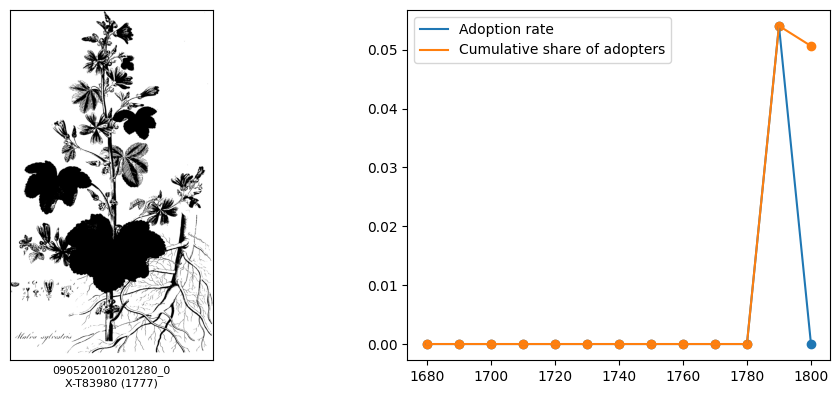

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


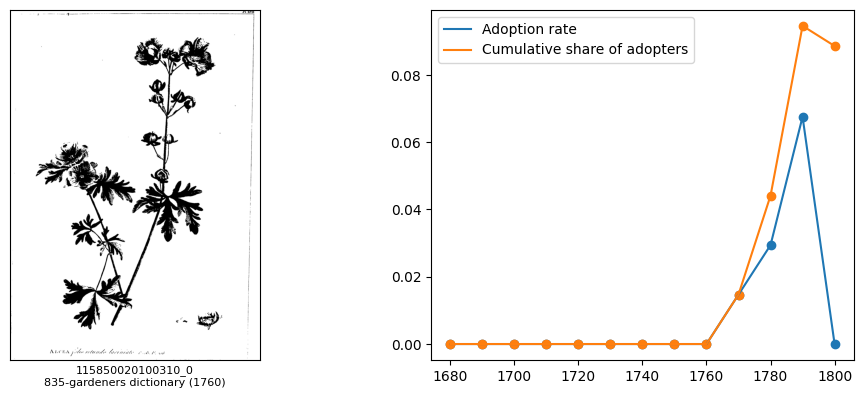

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


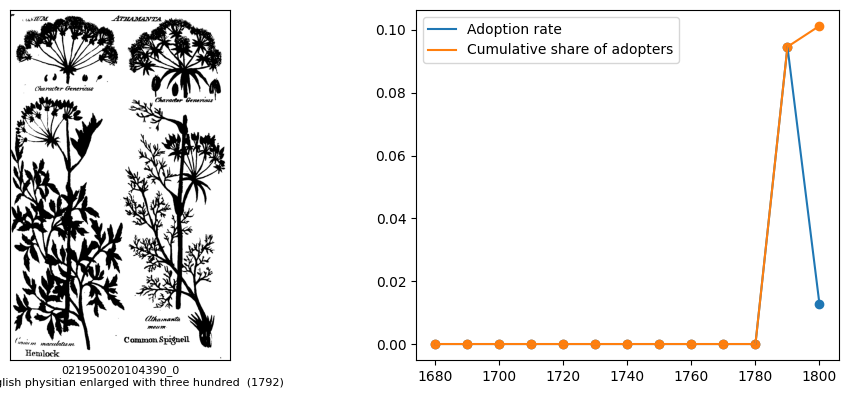

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


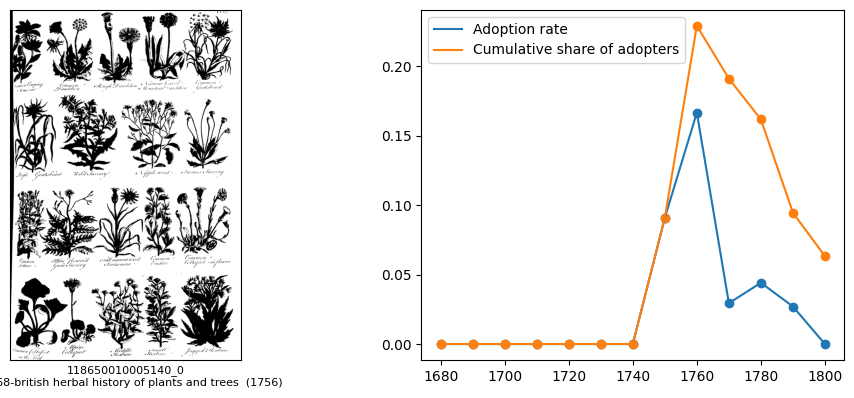

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


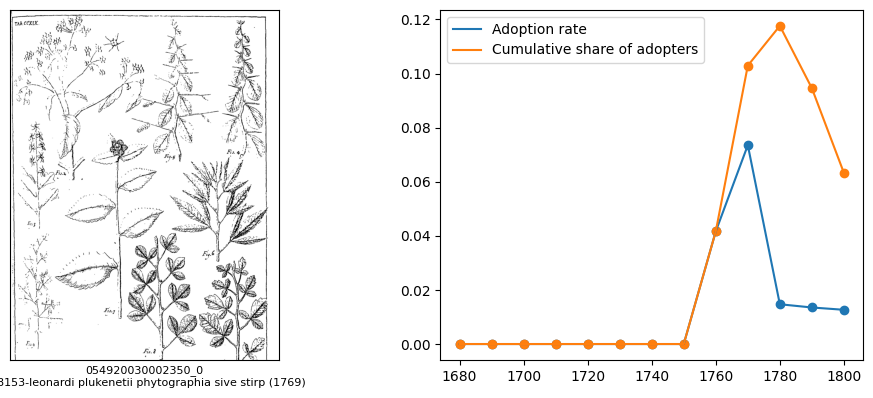

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


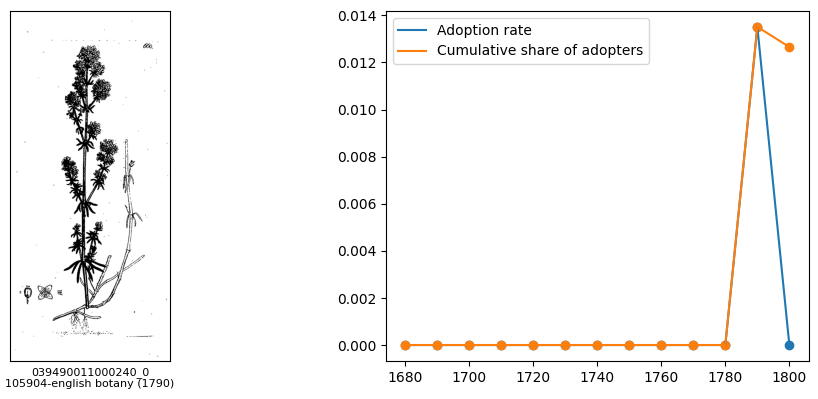

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


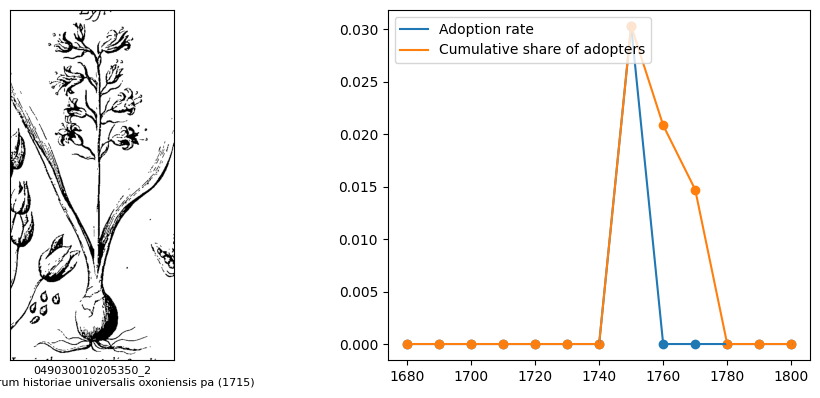

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


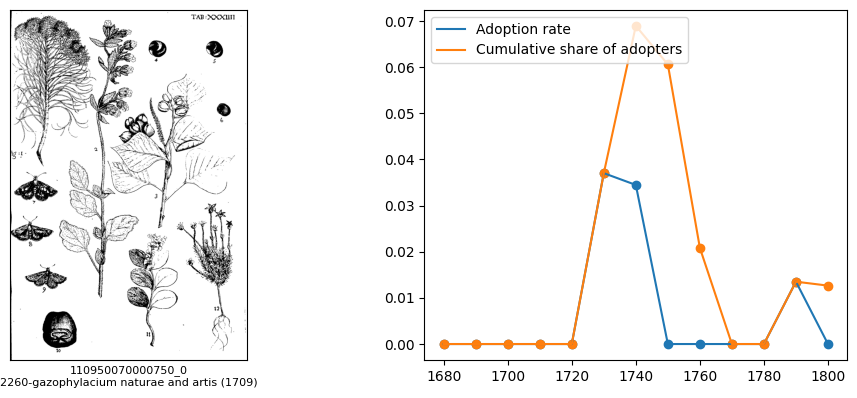

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


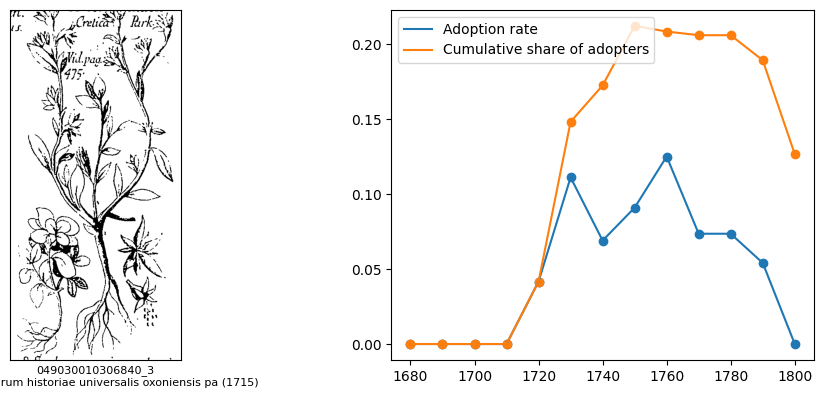

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1088242176.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


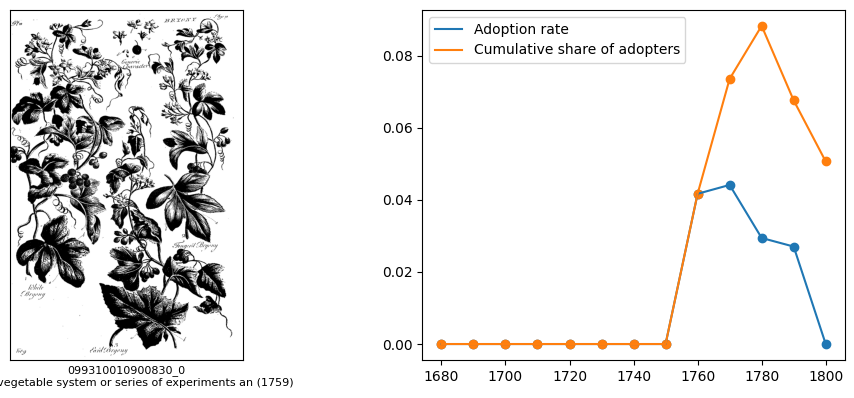

In [54]:
"""
Examining diffusion
- Get a randomly sampled set of 10 illustrations
- Calculate the adoption rate (new adopters/all potential adopters)
and accumulative share of adopters (accumulative number of adopters/all potential adopters)

As the number of all potential adopters (published works) were constantly growing, 
for each illustration we represent its adoption rate and accumulative share of adopters as below.
- Adoption rate: # of works that reuse it/market size for botanical works at that point
- Accumulative share of adopters: accumulative # of works that reuse it (with die-outs removed)/market size for botanical works at that point
"""

for img in reuses_094.sample(n=10).img_1:
    
    fig = plt.figure(figsize=(12, 10))

    file = Image.open(os.path.join(DATA_DIR, img+'.png'))
    info = diffusion_094[diffusion_094.img_1 == img].iloc[0]
    
    ax = []
    ax.append(fig.add_subplot(2, 2, 1))
    ax[0].set_xlabel(f'{img}\n{info.work_1[:50]} ({int(info.year_1)})', fontsize = 8)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    file = file.convert('RGB')
    plt.imshow(file)
    file.close()
    
    reuse_data = diffusion_094[diffusion_094['img_1']==img][['work_2', 'year_2']].drop_duplicates().sort_values(by=['work_2', 'year_2']).set_index('work_2')
    try:
        drop = [idx for idx, item in enumerate(list(reuse_data.index.duplicated(keep='first'))) if item==True]
        reuse_data = reuse_data.reset_index().drop(drop).sort_values(by=['year_2'])
    except:
        reuse_data = reuse_data.reset_index().sort_values(by=['year_2'])

    reuse_count = df_market.loc[reuse_data.work_2] #.sum(axis=0).reset_index().rename(columns={"index":"year_2", 0:"cumsum"})
    reuse_count['year'] = list(reuse_data['year_2'])

    for work_id in reuse_count.index:
        reuse_year = reuse_count.loc[work_id, 'year']
        if pd.isnull(reuse_year) == False:
            reuse_count.loc[work_id, :reuse_year-1] = [False] * len(reuse_count.loc[work_id, :reuse_year-1])
        else:
            reuse_count.drop([work_id])

    reuse_count = reuse_count.drop(columns=['year']).sum(axis=0).reset_index().rename(columns={"index":"year_2", 0:"cumsum"})
    reuse_count['decade'] = reuse_count.apply(lambda x: int(x['year_2']/10)*10, axis=1)
    reuse_count = reuse_count.groupby(by=['decade']).max().reset_index()
#     reuse_count = reuse_count[reuse_count['year_2'].isin(list(np.arange(1679, 1819, 10)) + [1800])].reset_index().drop(columns=['index'])
#     reuse_count['decade'] = reuse_count.apply(lambda x: int(x['year_2']/10)*10, axis=1)

    reuse_data = reuse_data.groupby(by=['year_2']).count().reset_index().rename(columns={"work_2":"count"}).sort_values(by=['year_2']).set_index('year_2')
    for year in range(1686, 1801):
        if year not in reuse_data.index:
            reuse_data.loc[year] = 0
    reuse_data = reuse_data.sort_index().reset_index()
    reuse_data['decade'] = reuse_data.apply(lambda x: int(x['year_2']/10)*10, axis=1)
    reuse_data = reuse_data[['decade', 'count']].groupby('decade').sum().reset_index()

    ax.append(fig.add_subplot(2, 2, 2))

    ax[1].plot(reuse_data['decade'], reuse_data['count']/normalize_decade['size']) 
    ax[1].plot(reuse_count['decade'], reuse_count['cumsum']/normalize_decade['size'])
    ax[1].scatter(reuse_data['decade'], reuse_data['count']/normalize_decade['size']) #/market_wdieout['size'])
    ax[1].scatter(reuse_count['decade'], reuse_count['cumsum']/normalize_decade['size']) #/market_wdieout['size'])
    
    ax[1].legend(['New adopters', 'Cumulative share of adopters'], loc='upper left')
    plt.show()

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


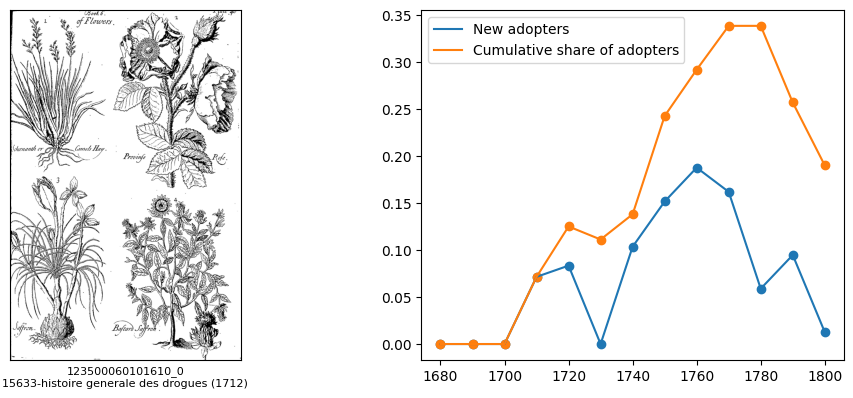

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


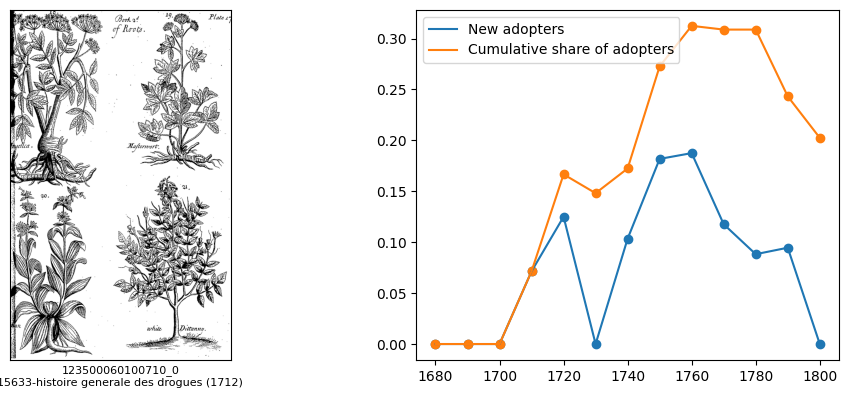

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


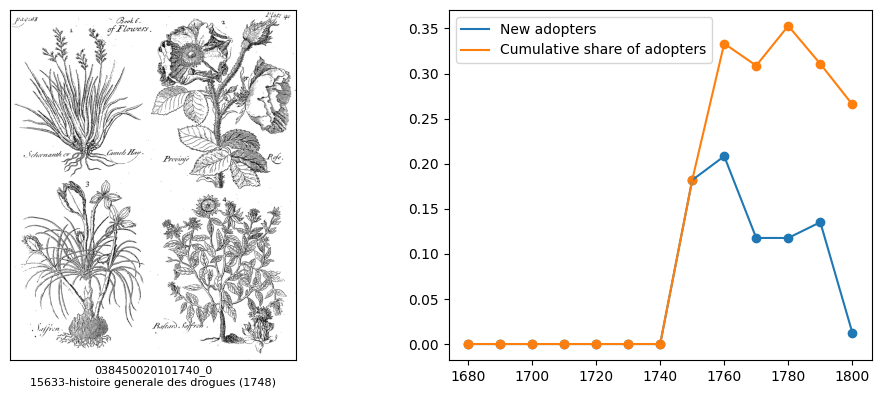

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


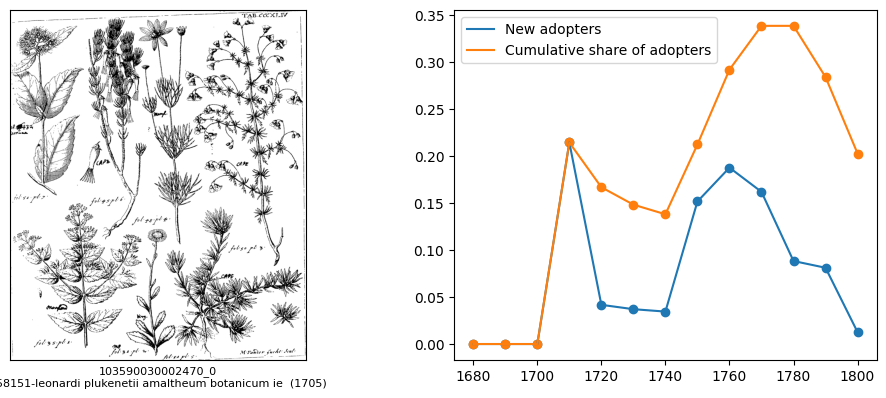

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


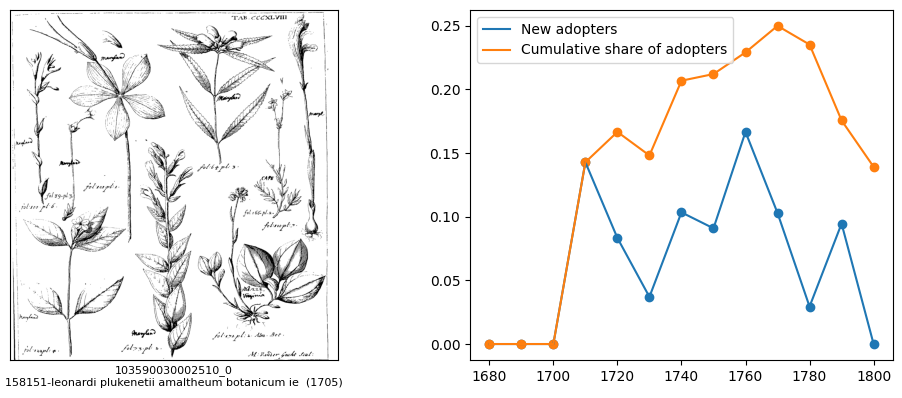

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


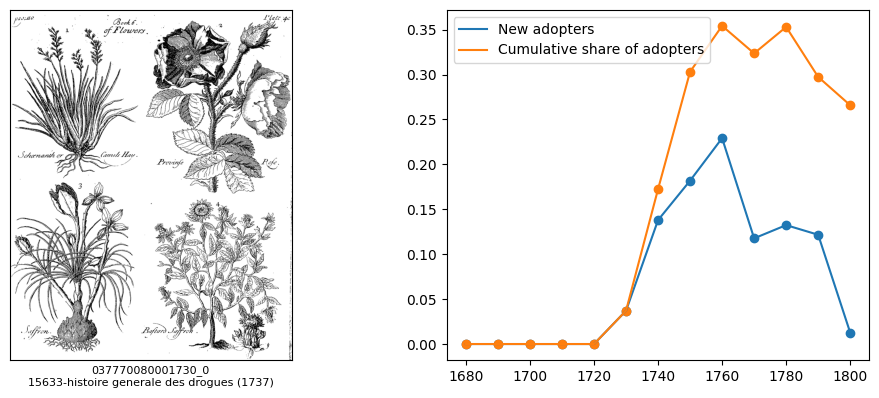

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


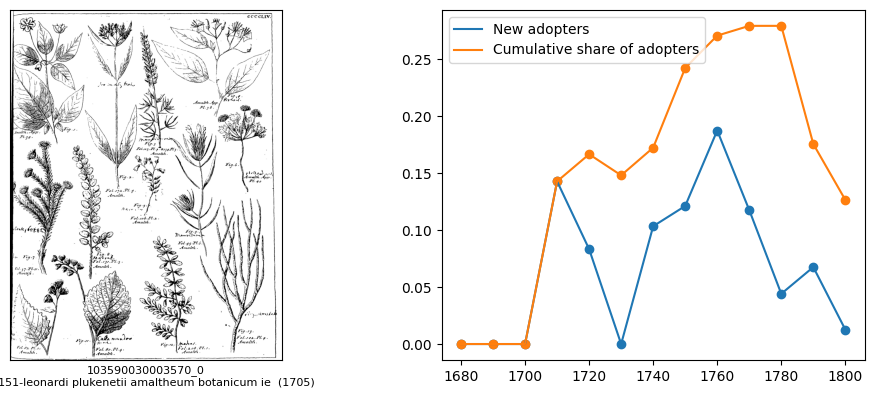

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


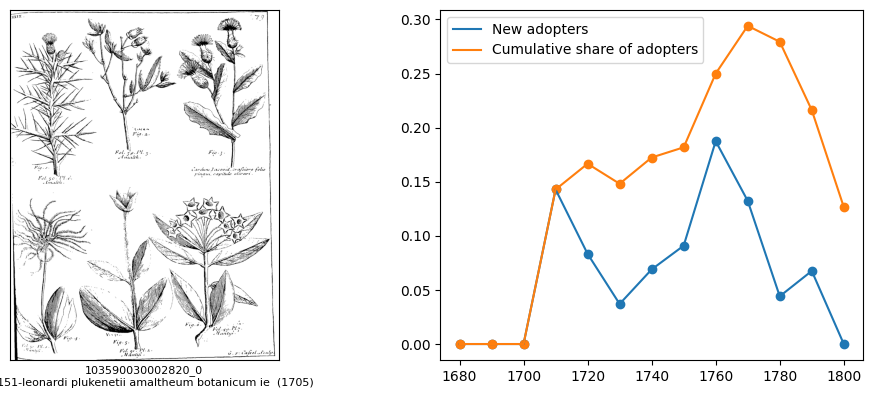

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


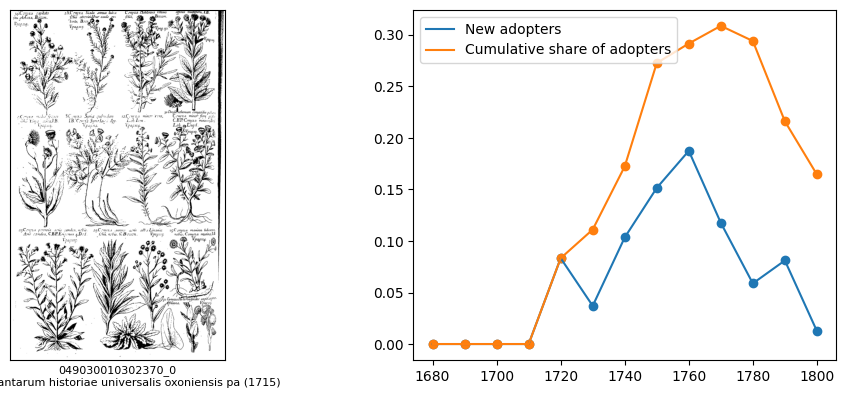

/var/folders/lc/yk3v2sms181c6hpd98wmbd900000gn/T/ipykernel_1718/1942267284.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reuse_count['year'] = list(reuse_data['year_2'])


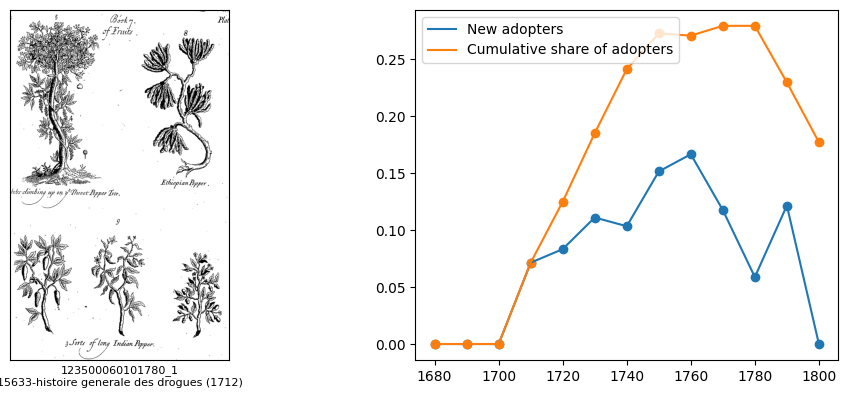

In [56]:
"""
Similar as above but using top 10 most reused illustrations
"""
for img in list(reuses_094[:10].img_1):    
    
        
    fig = plt.figure(figsize=(12, 10))

    file = Image.open(os.path.join(DATA_DIR, img+'.png'))
    info = diffusion_094[diffusion_094.img_1 == img].iloc[0]
    
    ax = []
    ax.append(fig.add_subplot(2, 2, 1))
    ax[0].set_xlabel(f'{img}\n{info.work_1[:50]} ({int(info.year_1)})', fontsize = 8)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    file = file.convert('RGB')
    plt.imshow(file)
    file.close()
    
    reuse_data = diffusion_094[diffusion_094['img_1']==img][['work_2', 'year_2']].drop_duplicates().sort_values(by=['work_2', 'year_2']).set_index('work_2')
    try:
        drop = [idx for idx, item in enumerate(list(reuse_data.index.duplicated(keep='first'))) if item==True]
        reuse_data = reuse_data.reset_index().drop(drop).sort_values(by=['year_2'])
    except:
        reuse_data = reuse_data.reset_index().sort_values(by=['year_2'])

    reuse_count = df_market.loc[reuse_data.work_2] #.sum(axis=0).reset_index().rename(columns={"index":"year_2", 0:"cumsum"})
    reuse_count['year'] = list(reuse_data['year_2'])

    for work_id in reuse_count.index:
        reuse_year = reuse_count.loc[work_id, 'year']
        if pd.isnull(reuse_year) == False:
            reuse_count.loc[work_id, :reuse_year-1] = [False] * len(reuse_count.loc[work_id, :reuse_year-1])
        else:
            reuse_count.drop([work_id])

    reuse_count = reuse_count.drop(columns=['year']).sum(axis=0).reset_index().rename(columns={"index":"year_2", 0:"cumsum"})
    reuse_count['decade'] = reuse_count.apply(lambda x: int(x['year_2']/10)*10, axis=1)
    reuse_count = reuse_count.groupby(by=['decade']).max().reset_index()
#     reuse_count = reuse_count[reuse_count['year_2'].isin(list(np.arange(1679, 1819, 10)) + [1800])].reset_index().drop(columns=['index'])
#     reuse_count['decade'] = reuse_count.apply(lambda x: int(x['year_2']/10)*10, axis=1)

    reuse_data = reuse_data.groupby(by=['year_2']).count().reset_index().rename(columns={"work_2":"count"}).sort_values(by=['year_2']).set_index('year_2')
    for year in range(1686, 1801):
        if year not in reuse_data.index:
            reuse_data.loc[year] = 0
    reuse_data = reuse_data.sort_index().reset_index()
    reuse_data['decade'] = reuse_data.apply(lambda x: int(x['year_2']/10)*10, axis=1)
    reuse_data = reuse_data[['decade', 'count']].groupby('decade').sum().reset_index()

    ax.append(fig.add_subplot(2, 2, 2))

    ax[1].plot(reuse_data['decade'], reuse_data['count']/normalize_decade['size']) 
    ax[1].plot(reuse_count['decade'], reuse_count['cumsum']/normalize_decade['size'])
    ax[1].scatter(reuse_data['decade'], reuse_data['count']/normalize_decade['size']) #/market_wdieout['size'])
    ax[1].scatter(reuse_count['decade'], reuse_count['cumsum']/normalize_decade['size']) #/market_wdieout['size'])
#     ax[1].set_xticks(np.arange(1670, 1810, 10))
    ax[1].legend(['New adopters', 'Cumulative share of adopters'], loc='upper left')
    plt.show()